In [1]:
import sys
sys.path.insert(1,"/home1/07064/tg863631/anaconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages") #work around for h5py
from cbrain.imports import *
from cbrain.cam_constants import *
from cbrain.utils import *
from cbrain.layers import *
from cbrain.data_generator import DataGenerator
import tensorflow as tf
from tensorflow import math as tfm
# import tensorflow_probability as tfp
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as imag
import scipy.integrate as sin
# import cartopy.crs as ccrs
import matplotlib.ticker as mticker
# from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import pickle
from climate_invariant import *
from tensorflow.keras import layers
import datetime


In [2]:
## This notebook builds on bf->inpRh->inpT->scaling->output

## DataGenerators

In [3]:
TRAINDIR = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'
path = '/home/ankitesh/CBrain_project/CBRAIN-CAM/cbrain/'
path_hyam = 'hyam_hybm.pkl'

hf = open(path+path_hyam,'rb')
hyam,hybm = pickle.load(hf)


In [4]:
TRAINFILE = 'CI_SP_M4K_train_shuffle.nc'
NORMFILE = 'CI_SP_M4K_NORM_norm.nc'
VALIDFILE = 'CI_SP_M4K_valid.nc'

In [5]:
scale_dict = load_pickle('/home/ankitesh/CBrain_project/CBRAIN-CAM/nn_config/scale_dicts/009_Wm2_scaling.pkl')
in_vars = ['QBP','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']

In [6]:
train_gen = DataGenerator(
    data_fn = TRAINDIR+TRAINFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=2048,
    shuffle=True,
    normalize_flag=True
)

In [7]:
valid_gen = DataGenerator(
    data_fn = TRAINDIR+VALIDFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=2048,
    shuffle=True,
    normalize_flag=True
)

### Generators using RH Inputs

In [8]:
scale_dict_RH = load_pickle('/home/ankitesh/CBrain_project/CBRAIN-CAM/nn_config/scale_dicts/009_Wm2_scaling.pkl')

In [9]:
scale_dict_RH['RH'] = 0.01*L_S/G, # Arbitrary 0.1 factor as specific humidity is generally below 2%

In [10]:
in_vars_RH = ['RH','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars_RH = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']

In [11]:
TRAINFILE_RH = 'CI_RH_M4K_NORM_train_shuffle.nc'
NORMFILE_RH = 'CI_RH_M4K_NORM_norm.nc'
VALIDFILE_RH = 'CI_RH_M4K_NORM_valid.nc'

In [12]:
train_gen_RH = DataGenerator(
    data_fn = TRAINDIR+TRAINFILE_RH,
    input_vars = in_vars_RH,
    output_vars = out_vars_RH,
    norm_fn = TRAINDIR+NORMFILE_RH,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict_RH,
    batch_size=2048,
    shuffle=True,
    normalize_flag=True
)

### Generators using T-TNS Inputs

In [13]:
in_vars = ['QBP','TfromNS','PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']

In [14]:
TRAINFILE_TNS = 'CI_TNS_M4K_NORM_train_shuffle.nc'
NORMFILE_TNS = 'CI_TNS_M4K_NORM_norm.nc'
VALIDFILE_TNS = 'CI_TNS_M4K_NORM_valid.nc'

In [15]:
train_gen_TNS = DataGenerator(
    data_fn = TRAINDIR+TRAINFILE_TNS,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE_TNS,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=2048,
    shuffle=True,
    normalize_flag=True
)

### Building the Network

In [16]:
class ScaleOp(layers.Layer):
    #if index = -1 that means take shflx+lhflx
    def __init__(self,index,inp_subQ, inp_divQ,**kwargs):
        self.scaling_index = index
        self.inp_subQ, self.inp_divQ =  np.array(inp_subQ), np.array(inp_divQ)
        super(ScaleOp,self).__init__(**kwargs)
        
        
    def get_config(self):
        config = {'index':self.scaling_index,'inp_subQ': list(self.inp_subQ), 'inp_divQ': list(self.inp_divQ)}
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
    
    def call(self,inps):      
        inp,op = inps
        #for scaling using LHFLX+SHFLX
        if self.scaling_index==-1:
            scaling_factor = (inp[:,62]*self.inp_divQ[62] + self.inp_subQ[62]) + (inp[:,63]*self.inp_divQ[63] + self.inp_subQ[63])
        else:
            scaling_factor = inp[:,self.scaling_index]*self.inp_divQ[self.scaling_index] + self.inp_subQ[self.scaling_index]
        
        op_updated = op[:,:60] * tf.expand_dims(scaling_factor,1)
        op_rest = op[:,60:]
        op = tf.concat((op_updated,op_rest),axis=1)
        return op



In [17]:
inp = Input(shape=(64,))

inpRH = QV2RH(inp_subQ=train_gen.input_transform.sub, 
              inp_divQ=train_gen.input_transform.div, 
              inp_subRH=train_gen_RH.input_transform.sub, 
              inp_divRH=train_gen_RH.input_transform.div, 
              hyam=hyam, hybm=hybm)(inp)

inpTNS = T2TmTNS(inp_subT=train_gen.input_transform.sub, 
              inp_divT=train_gen.input_transform.div, 
              inp_subTNS=train_gen_TNS.input_transform.sub, 
              inp_divTNS=train_gen_TNS.input_transform.div, 
              hyam=hyam, hybm=hybm)(inpRH)

densout = Dense(128, activation='linear')(inpTNS)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (6):
    densout = Dense(128, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
out = Dense(64, activation='linear')(densout)
out = ScaleOp(-1,
              inp_subQ=train_gen.input_transform.sub, 
              inp_divQ=train_gen.input_transform.div,
              )([inp,out])
model= tf.keras.models.Model(inp, out)

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64)]         0                                            
__________________________________________________________________________________________________
q_v2rh (QV2RH)                  (None, 64)           0           input_1[0][0]                    
__________________________________________________________________________________________________
t2_tm_tns (T2TmTNS)             (None, 64)           0           q_v2rh[0][0]                     
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          8320        t2_tm_tns[0][0]                  
______________________________________________________________________________________________

In [19]:
model.compile(tf.keras.optimizers.Adam(), loss=mse)

In [20]:
path_HDF5 = '/oasis/scratch/comet/ankitesh/temp_project/models/ScalingNet/'
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save_posBflx = ModelCheckpoint(path_HDF5+'RH_TNS_Scaling.hdf5',save_best_only=True, monitor='val_loss', mode='min')
logdir = os.path.join("/oasis/scratch/comet/ankitesh/temp_project/logs/RH_TNS_ScalingLogs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=0, update_freq=1000,embeddings_freq=1)

In [62]:
Nep = 10
model.fit_generator(train_gen, epochs=Nep, validation_data=valid_gen,\
              callbacks=[earlyStopping, mcp_save_posBflx,tensorboard_callback])

Epoch 1/10
  135/20688 [..............................] - ETA: 47:33 - loss: 3980.5267

KeyboardInterrupt: 

## Model Diagonistics 

In [21]:
path_HDF5 = '/oasis/scratch/comet/ankitesh/temp_project/models/ScalingNet/' # Path to NN weights
config_file = 'CI_SP_M4K_CONFIG.yml' # Configuration file
data_file = ['CI_SP_M4K_valid.nc','CI_SP_P4K_valid.nc'] # Validation/test data sets
NNarray = ['CI01_RH_TNS.hdf5','RH_TNS_ScaLH.hdf5','RH_TNS_ScaLHSH.hdf5'] # NN to evaluate
NNname = ['RH TNS', 'RH TNS LH', 'RH TNS LHSH'] # Name of NNs for plotting
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer,
            'QV2RH':QV2RH,'T2TmTNS':T2TmTNS,'eliq':eliq,'eice':eice,'esat':esat,'qv':qv,'RH':RH, 
             'ScaleOp':ScaleOp }

In [22]:
# Indices of different variables
PHQ_idx = slice(0,30)
TPHYSTND_idx = slice(30,60)

In [23]:
NN = {}; md = {};
%cd $TRAINDIR/HDF5_DATA
for i,NNs in enumerate(NNarray):
    print('NN name is ',NNs)
    path = path_HDF5+NNs
    NN[NNs] = load_model(path,custom_objects=dict_lay)
    md[NNs] = {}
    for j,data in enumerate(data_file):
        print('data name is ',data)
        md[NNs][data[6:-3]] = ModelDiagnostics(NN[NNs],
                                                '/home/ankitesh/CBrain_project/PrepData/'+config_file,
                                                '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'+data)

[Errno 2] No such file or directory: '/oasis/scratch/comet/ankitesh/temp_project/PrepData//HDF5_DATA'
/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog
NN name is  CI01_RH_TNS.hdf5
data name is  CI_SP_M4K_valid.nc
data name is  CI_SP_P4K_valid.nc
NN name is  RH_TNS_ScaLH.hdf5


/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


data name is  CI_SP_M4K_valid.nc
data name is  CI_SP_P4K_valid.nc
NN name is  RH_TNS_ScaLHSH.hdf5


/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


data name is  CI_SP_M4K_valid.nc
data name is  CI_SP_P4K_valid.nc


/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [24]:
lat_ind = np.arange(26,40)
iinis = [414,200,312,111]
# iini = 414 # Initial time to sample
# iend = iini+47 # One day later
diagno = {} # Diagnostics structure
diagno['truth'] = {} # Diagnostics structure for the truth
for i,NNs in enumerate(NNarray):
    print('i=',i,'& NNs=',NNs,'         ')
    diagno[NNs] = {} # Diagnostics structure for each NN
    for j,data in enumerate(data_file):
        diagno[NNs][data[6:-3]]={}
        if i==0: diagno['truth'][data[6:-3]]={}
        for iini in iinis:
            
            print('j=',j,'& iini=',iini,'& data=',data,'         ',end='\r'),
            
            iend = iini+47
            diagno[NNs][data[6:-3]][iini] = {} # Diagnostics structure for each data file
            if i==0: diagno['truth'][data[6:-3]][iini] = {}
            for itime in tqdm(np.arange(iini,iend)):
                # Get input, prediction and truth from NN
                inp, p, truth = md[NNs][data[6:-3]].get_inp_pred_truth(itime)  # [lat, lon, var, lev]
                p = np.array(p)
                # Get convective heating and moistening for each NN
                if itime==iini:
                    if i==0:
                        diagno['truth'][data[6:-3]][iini]['PHQ'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
                        diagno['truth'][data[6:-3]][iini]['TPHYSTND'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]

                    diagno[NNs][data[6:-3]][iini]['PHQ'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
                    diagno[NNs][data[6:-3]][iini]['TPHYSTND'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]
                else:
                    for istr,field in enumerate(['PHQ','TPHYSTND']):
                        if field=='PHQ': ind_field = PHQ_idx
                        elif field=='TPHYSTND': ind_field = TPHYSTND_idx
                        diagno[NNs][data[6:-3]][iini][field] = np.concatenate((diagno[NNs][data[6:-3]][iini][field],
                                                             md[NNs][data[6:-3]].\
                                                             reshape_ngeo(p[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                            axis=3)
                        if i==0:
                            diagno['truth'][data[6:-3]][iini][field] = np.concatenate((diagno['truth'][data[6:-3]][iini][field],
                                                                     md[NNs][data[6:-3]].\
                                                                     reshape_ngeo(truth[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                                    axis=3)



i= 0 & NNs= CI01_RH_TNS.hdf5          


/home/ankitesh/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



i= 1 & NNs= RH_TNS_ScaLH.hdf5          



i= 2 & NNs= RH_TNS_ScaLHSH.hdf5          


In [25]:
# Load coordinates (just pick any file from the climate model run)
coor = xr.open_dataset("/oasis/scratch/comet/ankitesh/temp_project/data/sp8fbp_minus4k.cam2.h1.0000-01-01-00000.nc",\
                    decode_times=False)
lat = coor.lat; lon = coor.lon; lev = coor.lev;
coor.close();

In [26]:
fz = 20
lw = 4
plt.rc('text',usetex=False)
plt.rc('font',size=fz)
plt.rc('font',**{'family':'serif','serif':['Computer Modern Roman']}, size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

In [31]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

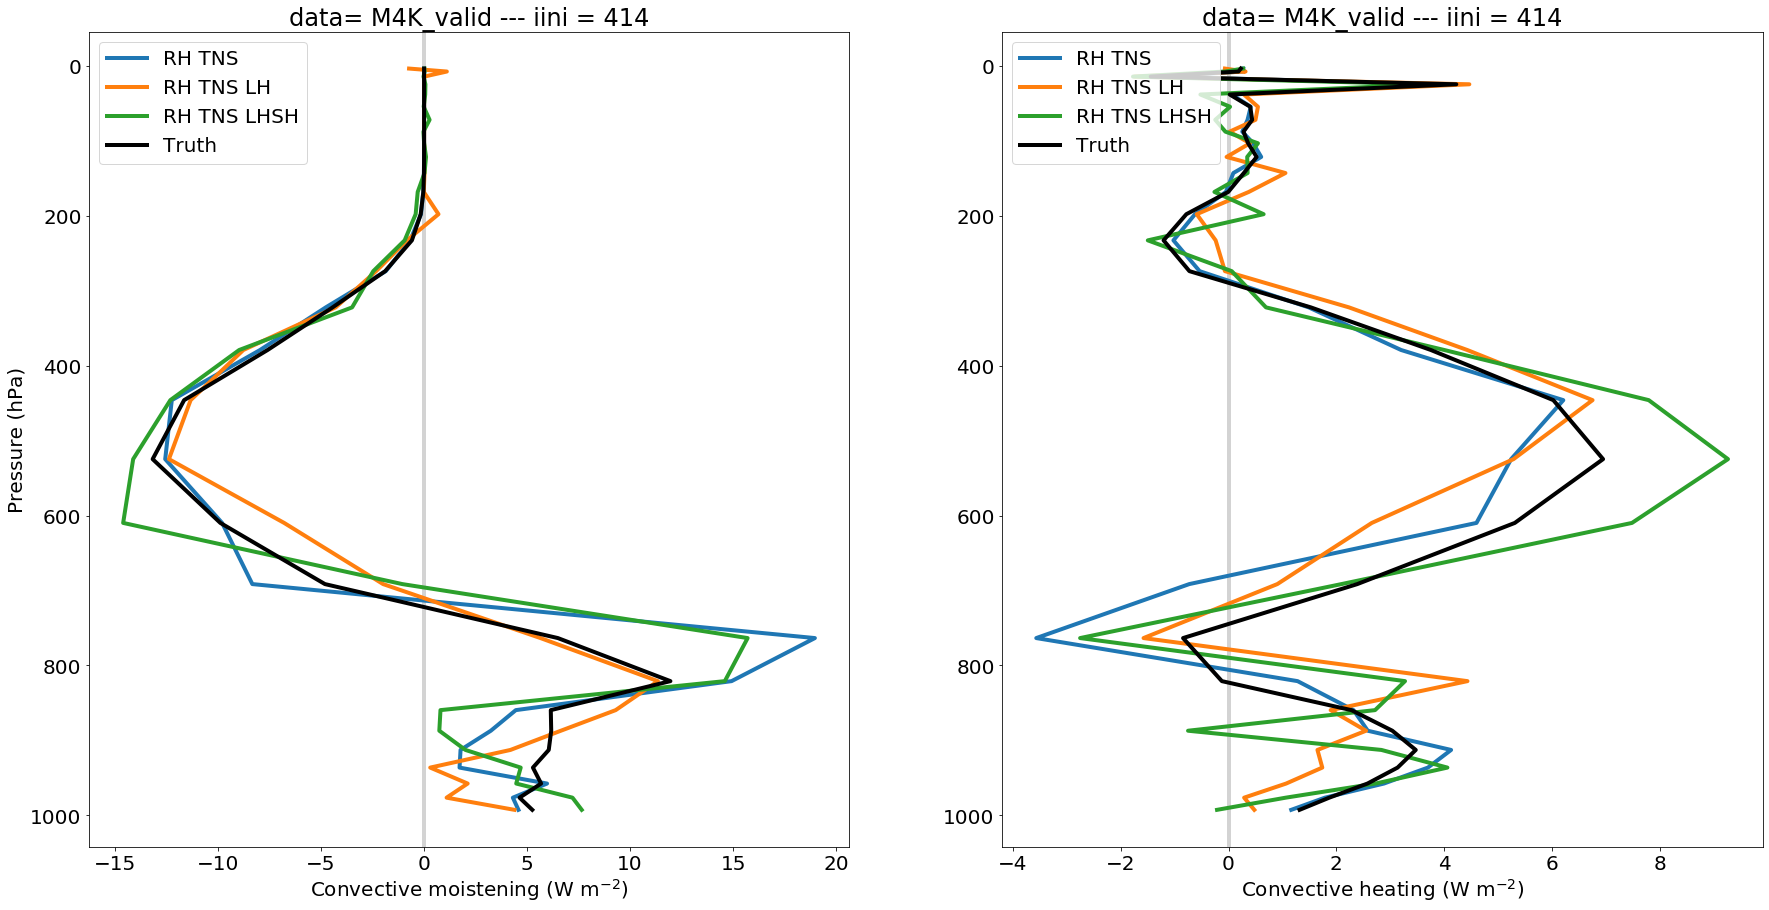

In [48]:


data = 'M4K_valid'
plt.figure(figsize=(30,15))
iini = iinis[0]
plt.subplot(1,2,1)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['PHQ'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['PHQ'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
plt.title('data= '+data+' '+ '--- iini = '+str(iini))


plt.subplot(1,2,2)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective heating ($\mathrm{W\ m^{-2}}$)')
plt.title('data= '+data+' '+ '--- iini = '+str(iini))
plt.gca().invert_yaxis()


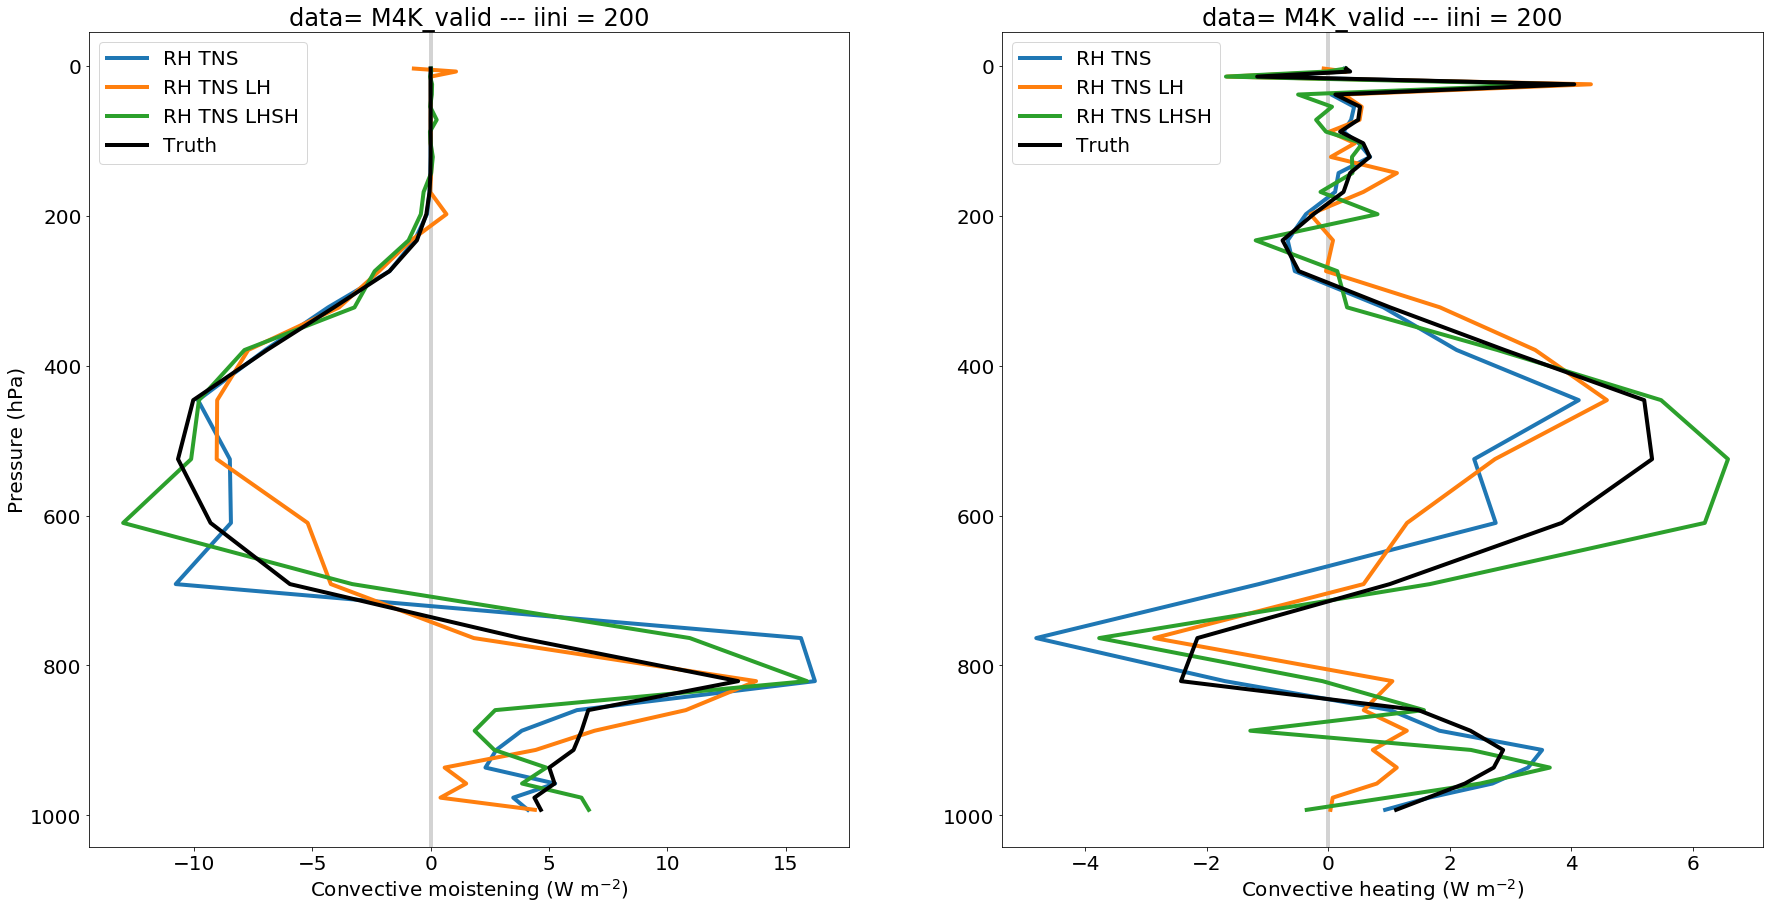

In [49]:


data = 'M4K_valid'
plt.figure(figsize=(30,15))
iini = iinis[1]
plt.subplot(1,2,1)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['PHQ'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['PHQ'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
plt.title('data= '+data+' '+ '--- iini = '+str(iini))


plt.subplot(1,2,2)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective heating ($\mathrm{W\ m^{-2}}$)')
plt.title('data= '+data+' '+ '--- iini = '+str(iini))
plt.gca().invert_yaxis()


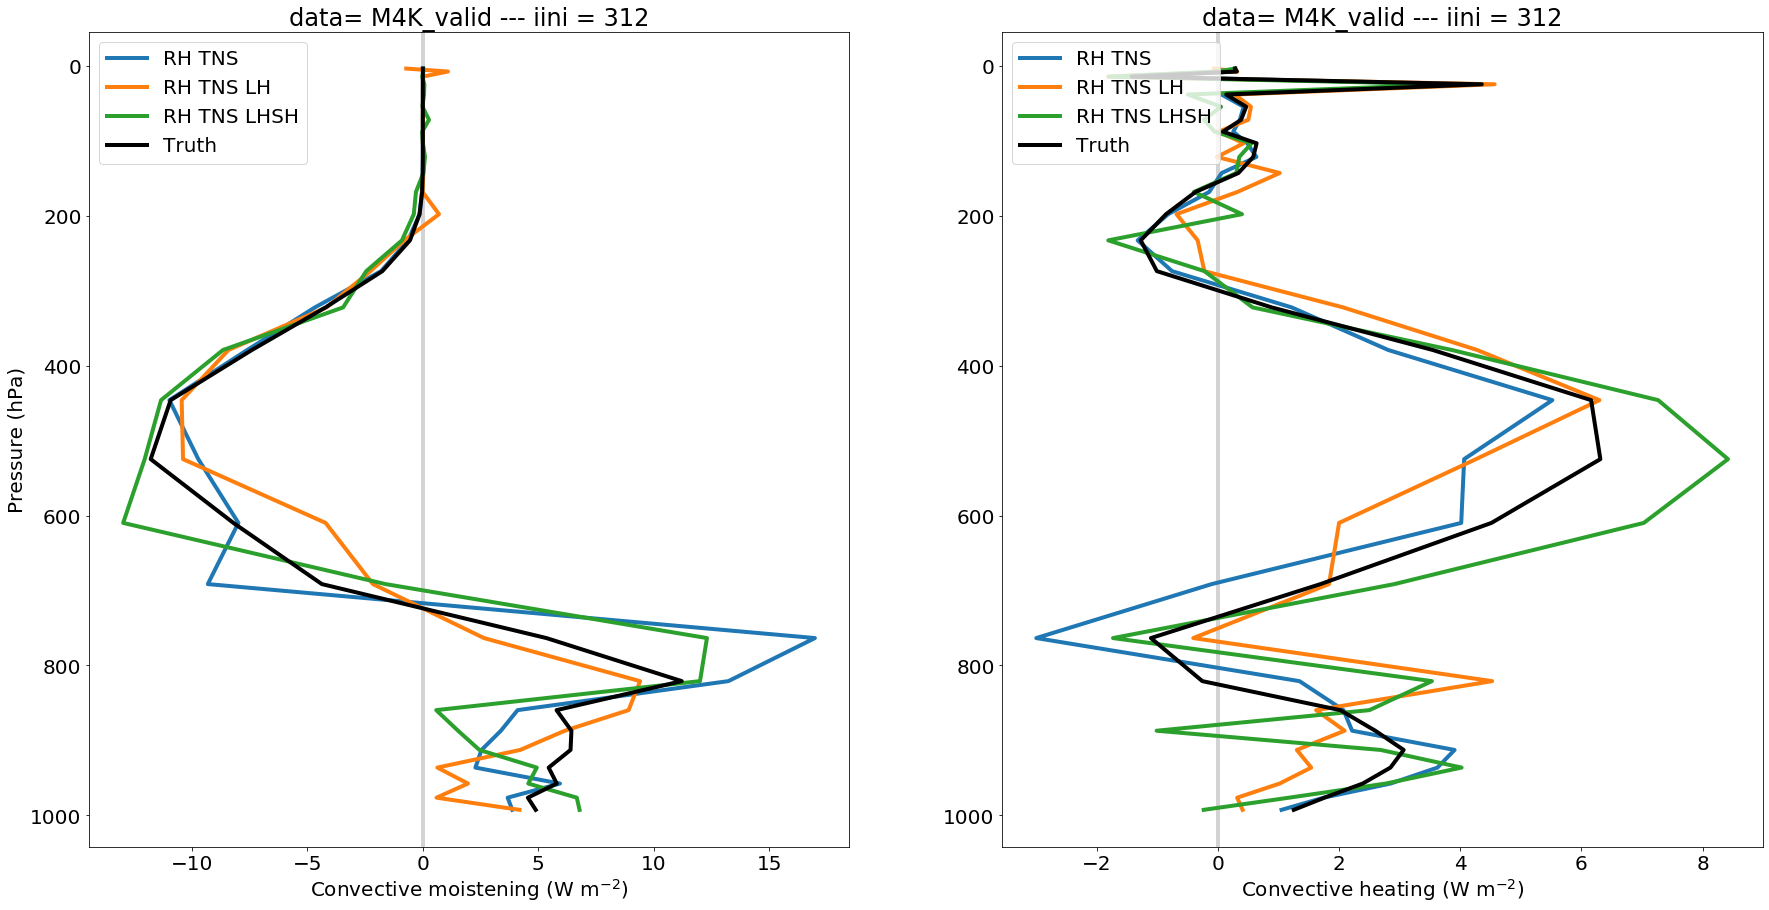

In [50]:


data = 'M4K_valid'
plt.figure(figsize=(30,15))
iini = iinis[2]
plt.subplot(1,2,1)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['PHQ'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['PHQ'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
plt.title('data= '+data+' '+ '--- iini = '+str(iini))


plt.subplot(1,2,2)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective heating ($\mathrm{W\ m^{-2}}$)')
plt.title('data= '+data+' '+ '--- iini = '+str(iini))
plt.gca().invert_yaxis()


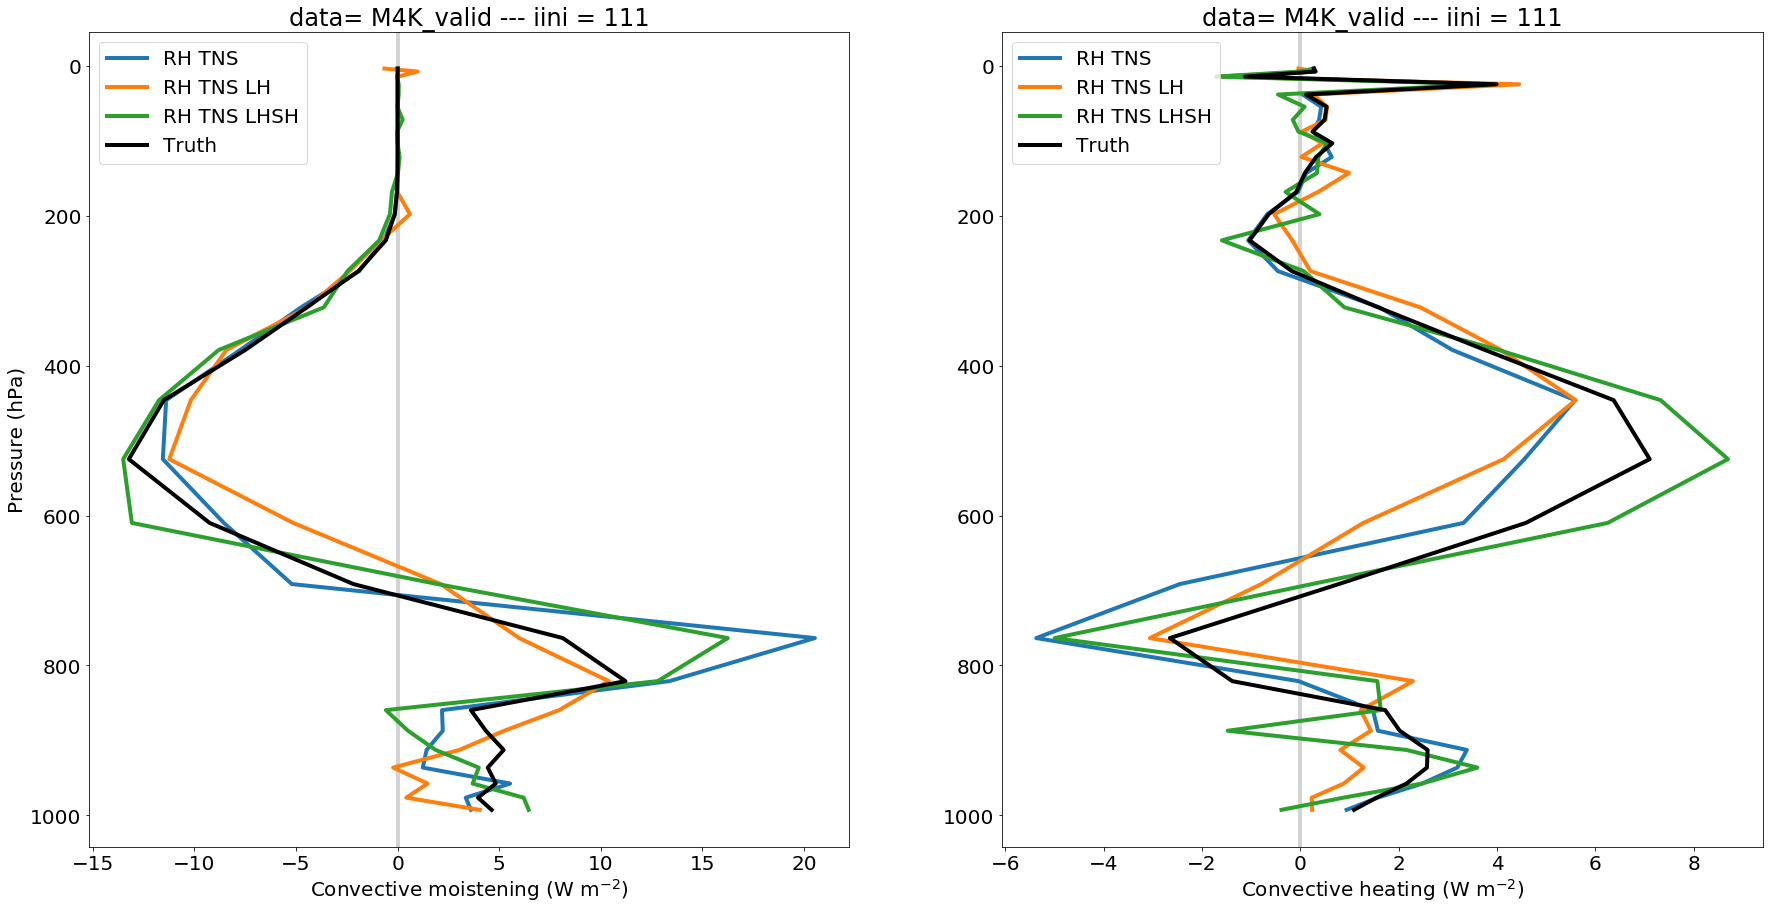

In [51]:


data = 'M4K_valid'
plt.figure(figsize=(30,15))
iini = iinis[3]
plt.subplot(1,2,1)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['PHQ'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['PHQ'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
plt.title('data= '+data+' '+ '--- iini = '+str(iini))


plt.subplot(1,2,2)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective heating ($\mathrm{W\ m^{-2}}$)')
plt.title('data= '+data+' '+ '--- iini = '+str(iini))
plt.gca().invert_yaxis()


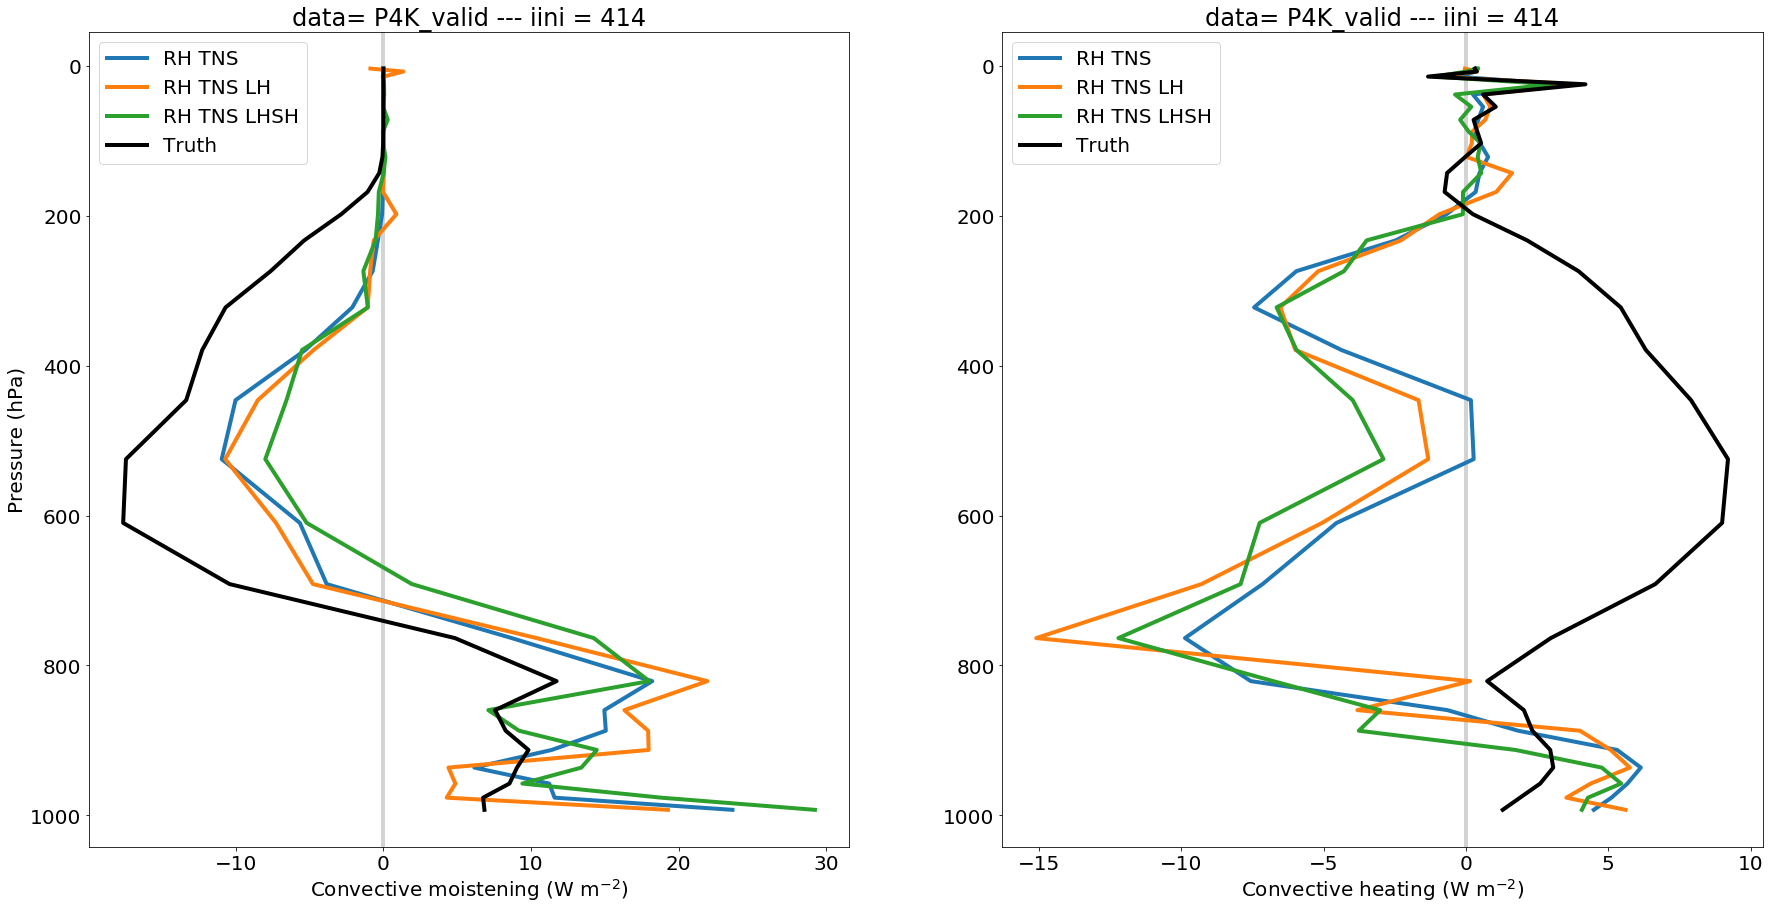

In [52]:


data = 'P4K_valid'
plt.figure(figsize=(30,15))
iini = iinis[0]
plt.subplot(1,2,1)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['PHQ'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['PHQ'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
plt.title('data= '+data+' '+ '--- iini = '+str(iini))


plt.subplot(1,2,2)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective heating ($\mathrm{W\ m^{-2}}$)')
plt.title('data= '+data+' '+ '--- iini = '+str(iini))
plt.gca().invert_yaxis()


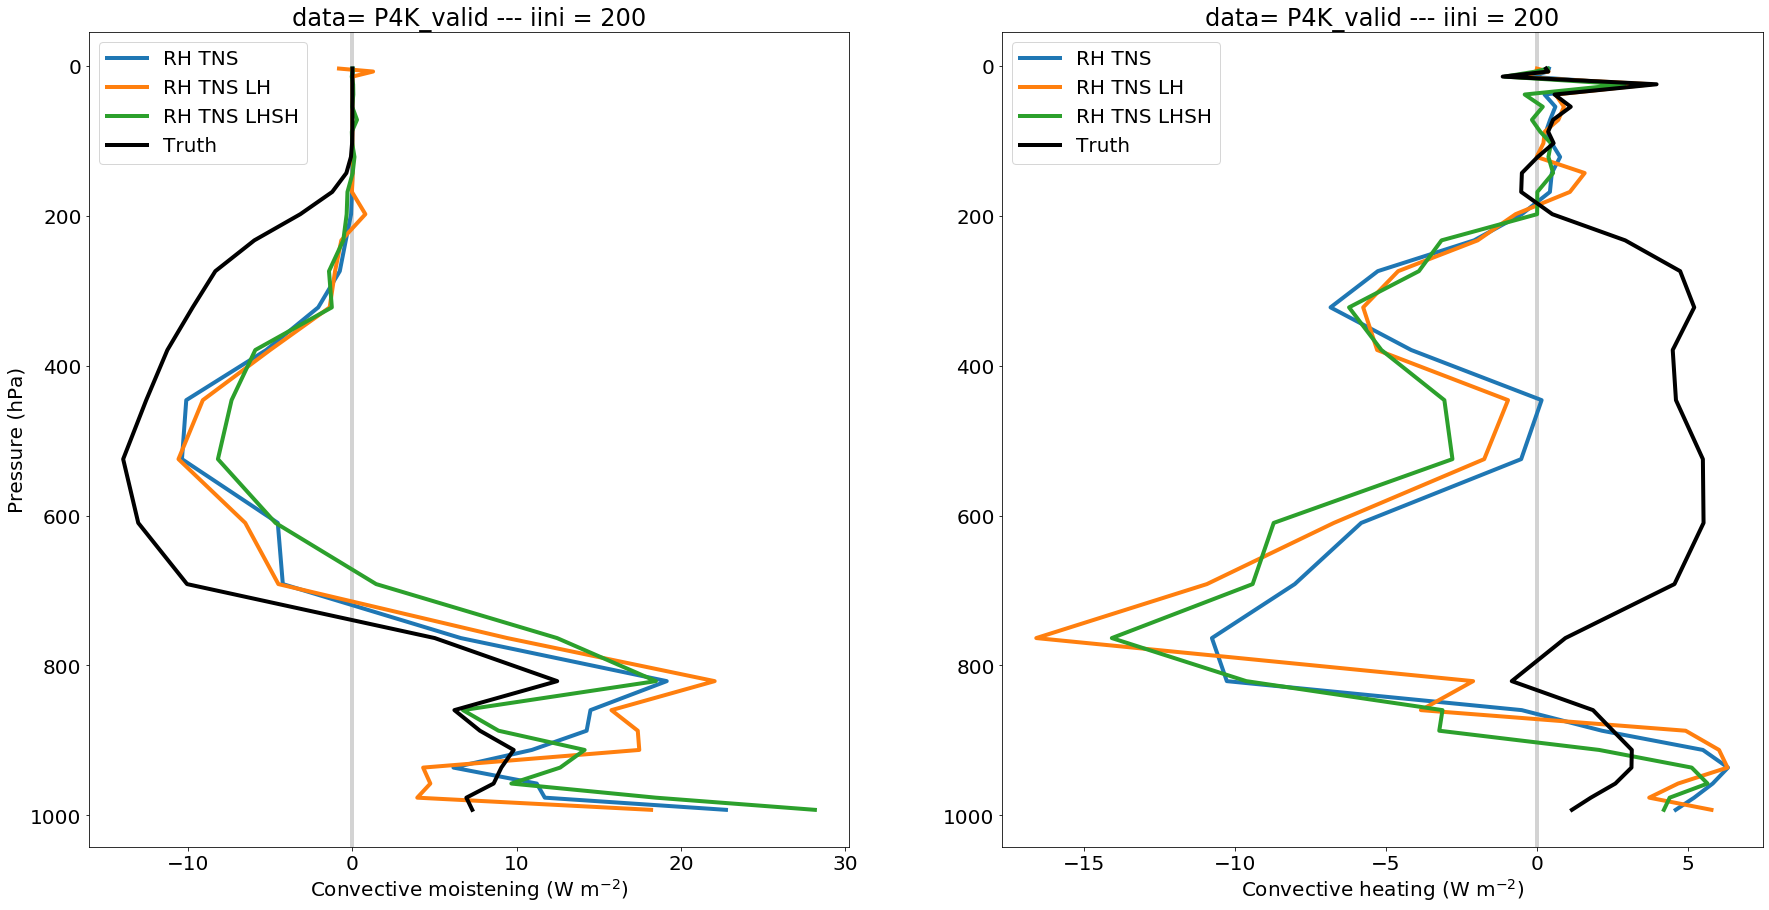

In [53]:


data = 'P4K_valid'
plt.figure(figsize=(30,15))
iini = iinis[1]
plt.subplot(1,2,1)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['PHQ'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['PHQ'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
plt.title('data= '+data+' '+ '--- iini = '+str(iini))


plt.subplot(1,2,2)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective heating ($\mathrm{W\ m^{-2}}$)')
plt.title('data= '+data+' '+ '--- iini = '+str(iini))
plt.gca().invert_yaxis()


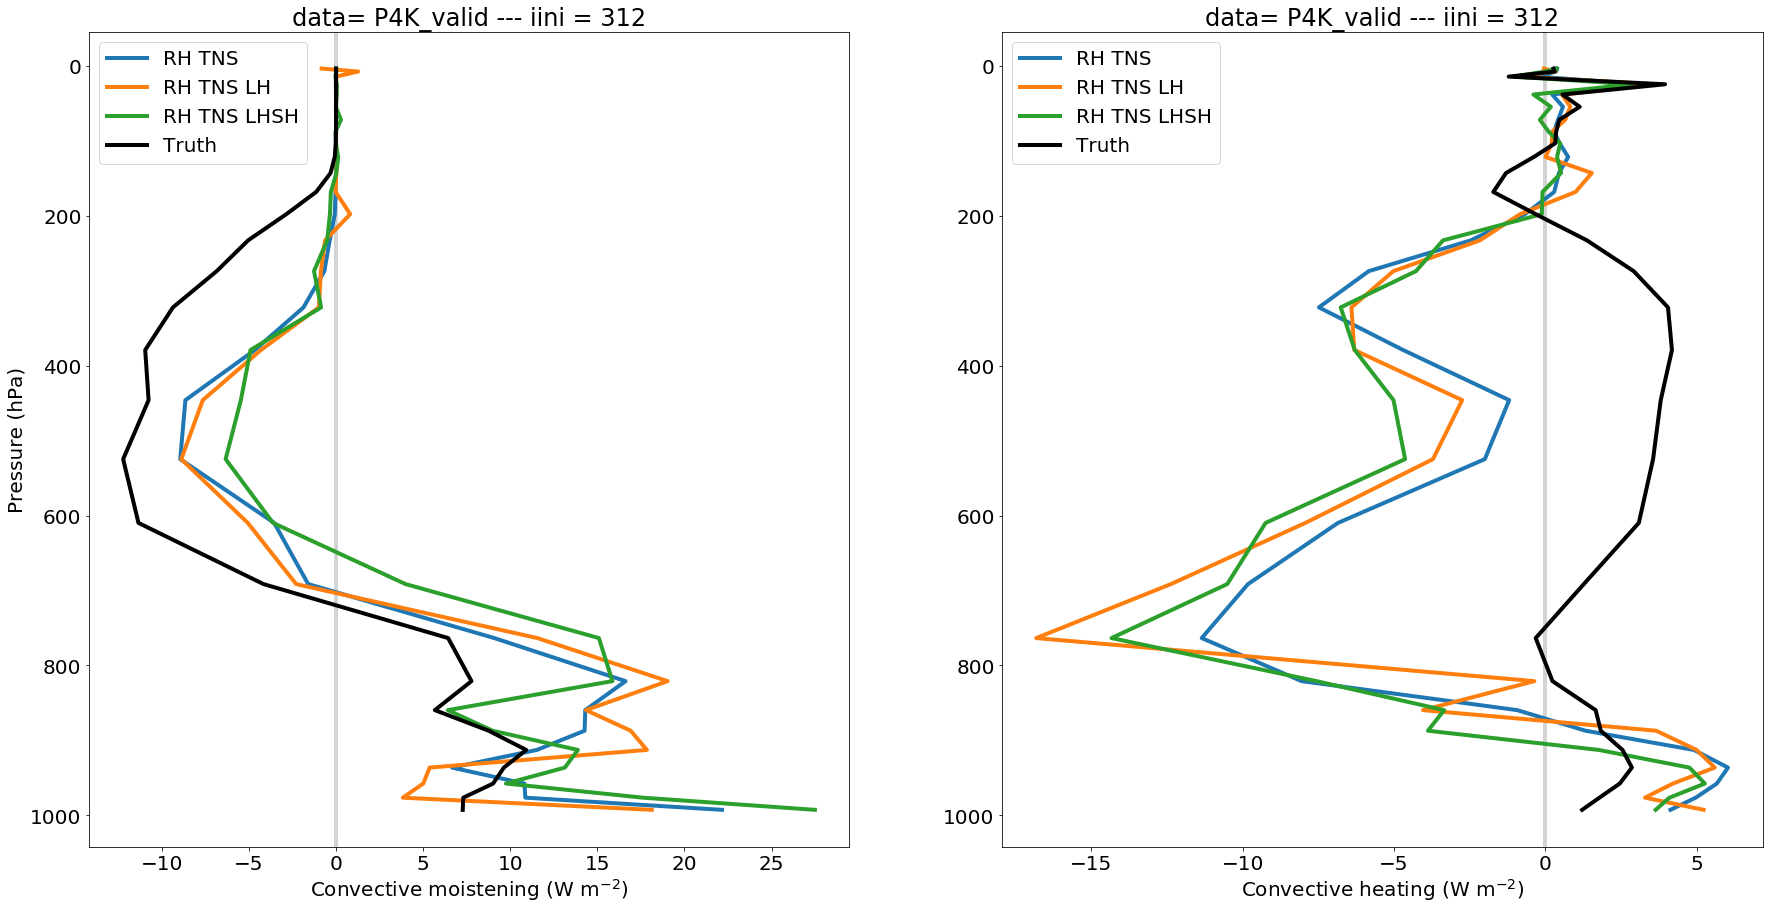

In [54]:


data = 'P4K_valid'
plt.figure(figsize=(30,15))
iini = iinis[2]
plt.subplot(1,2,1)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['PHQ'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['PHQ'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
plt.title('data= '+data+' '+ '--- iini = '+str(iini))


plt.subplot(1,2,2)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective heating ($\mathrm{W\ m^{-2}}$)')
plt.title('data= '+data+' '+ '--- iini = '+str(iini))
plt.gca().invert_yaxis()


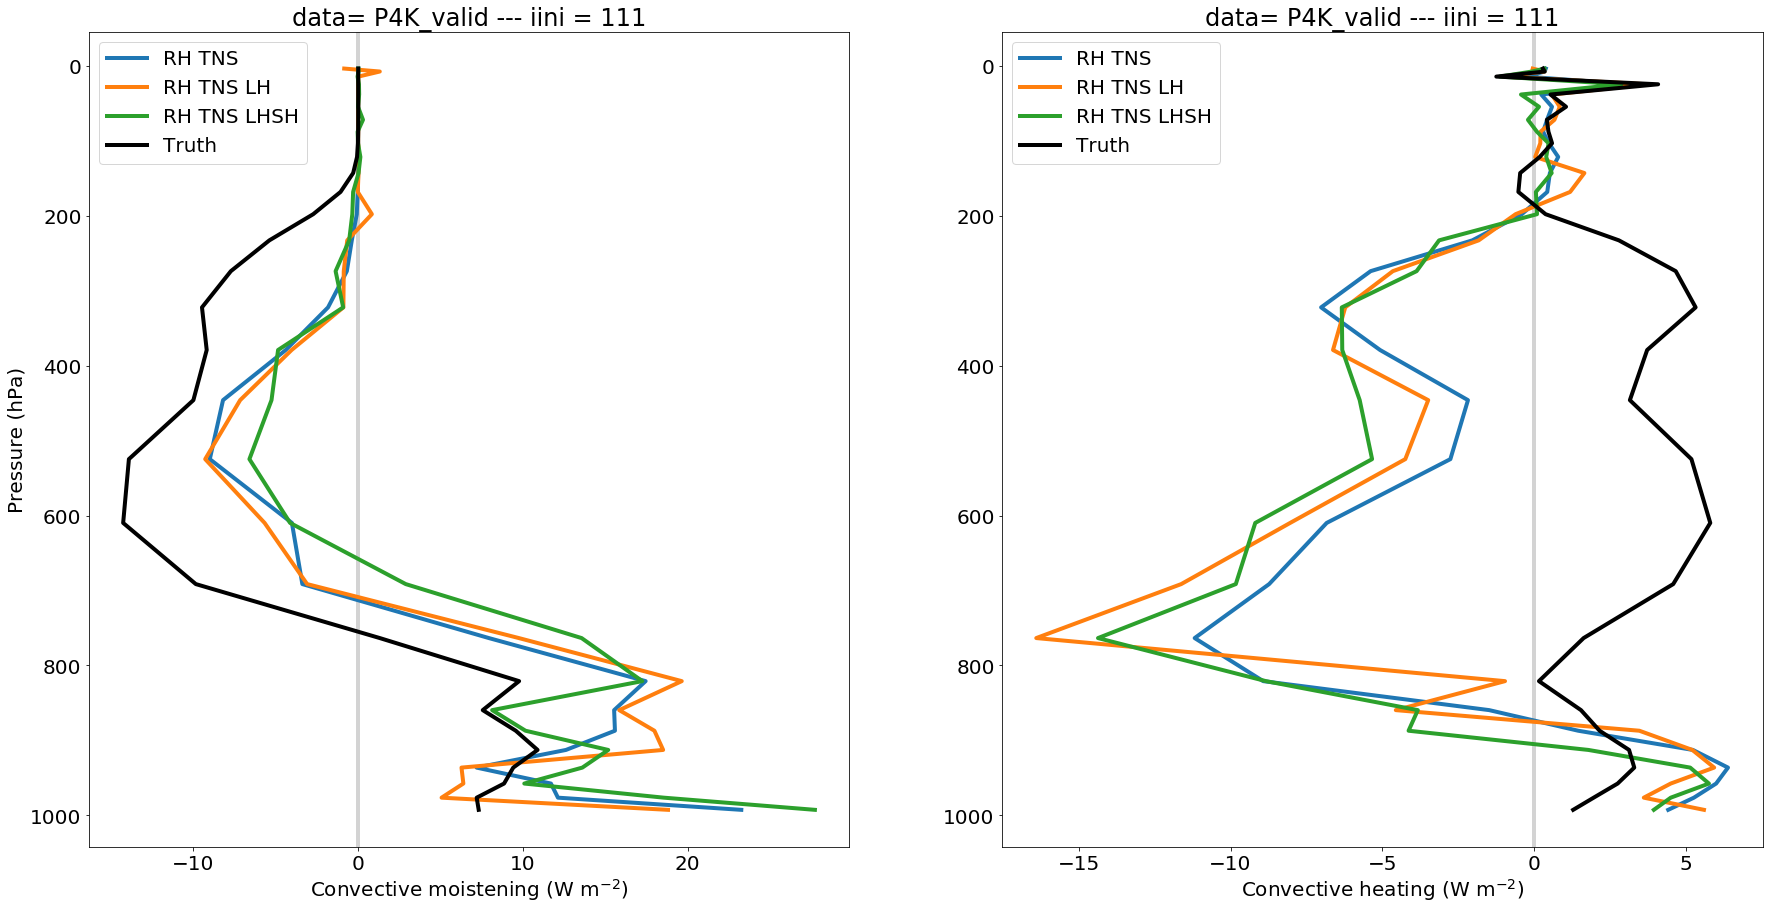

In [55]:


data = 'P4K_valid'
plt.figure(figsize=(30,15))
iini = iinis[3]
plt.subplot(1,2,1)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['PHQ'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['PHQ'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
plt.title('data= '+data+' '+ '--- iini = '+str(iini))


plt.subplot(1,2,2)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective heating ($\mathrm{W\ m^{-2}}$)')
plt.title('data= '+data+' '+ '--- iini = '+str(iini))
plt.gca().invert_yaxis()
